In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 加载数据集
df = pd.read_csv('C:/Users/zhouxiinlei/Documents/GitHub/ml_WaterAnalytics/dataset/Lake/Lake_Bilancino.csv')
df.head()

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,03/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
1,04/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2,05/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
3,06/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
4,07/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.44,0.31


In [25]:
data_info = df.info()
data_description = df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6603 entries, 0 to 6602
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  6603 non-null   object 
 1   Rainfall_S_Piero      6026 non-null   float64
 2   Rainfall_Mangona      6026 non-null   float64
 3   Rainfall_S_Agata      6026 non-null   float64
 4   Rainfall_Cavallina    6026 non-null   float64
 5   Rainfall_Le_Croci     6026 non-null   float64
 6   Temperature_Le_Croci  6025 non-null   float64
 7   Lake_Level            6603 non-null   float64
 8   Flow_Rate             6582 non-null   float64
dtypes: float64(8), object(1)
memory usage: 464.4+ KB


Date                      0
Rainfall_S_Piero        577
Rainfall_Mangona        577
Rainfall_S_Agata        577
Rainfall_Cavallina      577
Rainfall_Le_Croci       577
Temperature_Le_Croci    578
Lake_Level                0
Flow_Rate                21
dtype: int64


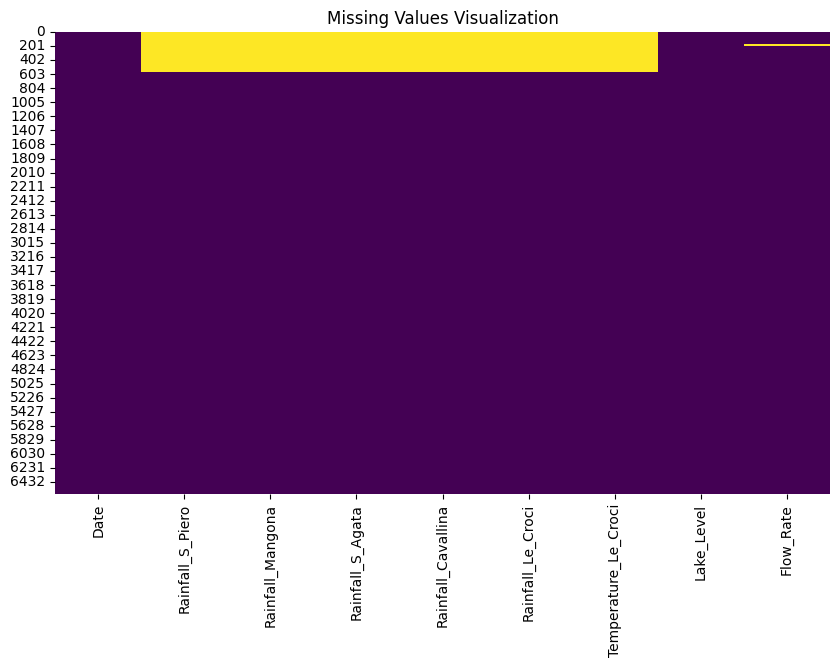

In [26]:
# 缺失值统计
missing_counts = df.isnull().sum()
print(missing_counts)

# 缺失值可视化
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Visualization')
plt.show()

In [ ]:
# 删除包含空白数据的行
df_cleaned = df.dropna().reset_index(drop=True)

In [28]:
# 使用滑动窗口平滑数据，窗口大小设置为7
window_size = 7
df_smoothed = df_cleaned.copy()

# 对除 "Date" 列外的所有列应用滑动窗口平滑
for column in df_cleaned.columns[1:]:
    df_smoothed[column] = df_cleaned[column].rolling(window=window_size).mean()

# 剔除开始部分的NaN值（由于滑动窗口的效果）
df_smoothed = df_smoothed.dropna().reset_index(drop=True)

# 将"Date"列转换为日期格式
df_smoothed['Date'] = pd.to_datetime(df_smoothed['Date'], dayfirst=True)

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,09/06/2002,0.0,0.0,0.4,0.0,0.0,6.5,249.470000,0.330000
1,10/06/2002,0.0,0.0,0.4,0.0,0.0,6.5,249.491429,0.354286
2,11/06/2002,0.0,0.0,0.4,0.0,0.0,6.5,249.511429,0.378571
3,12/06/2002,0.0,0.0,0.4,0.0,0.0,6.5,249.531429,0.402857
4,13/06/2002,0.0,0.0,0.4,0.0,0.0,6.5,249.551429,0.427143


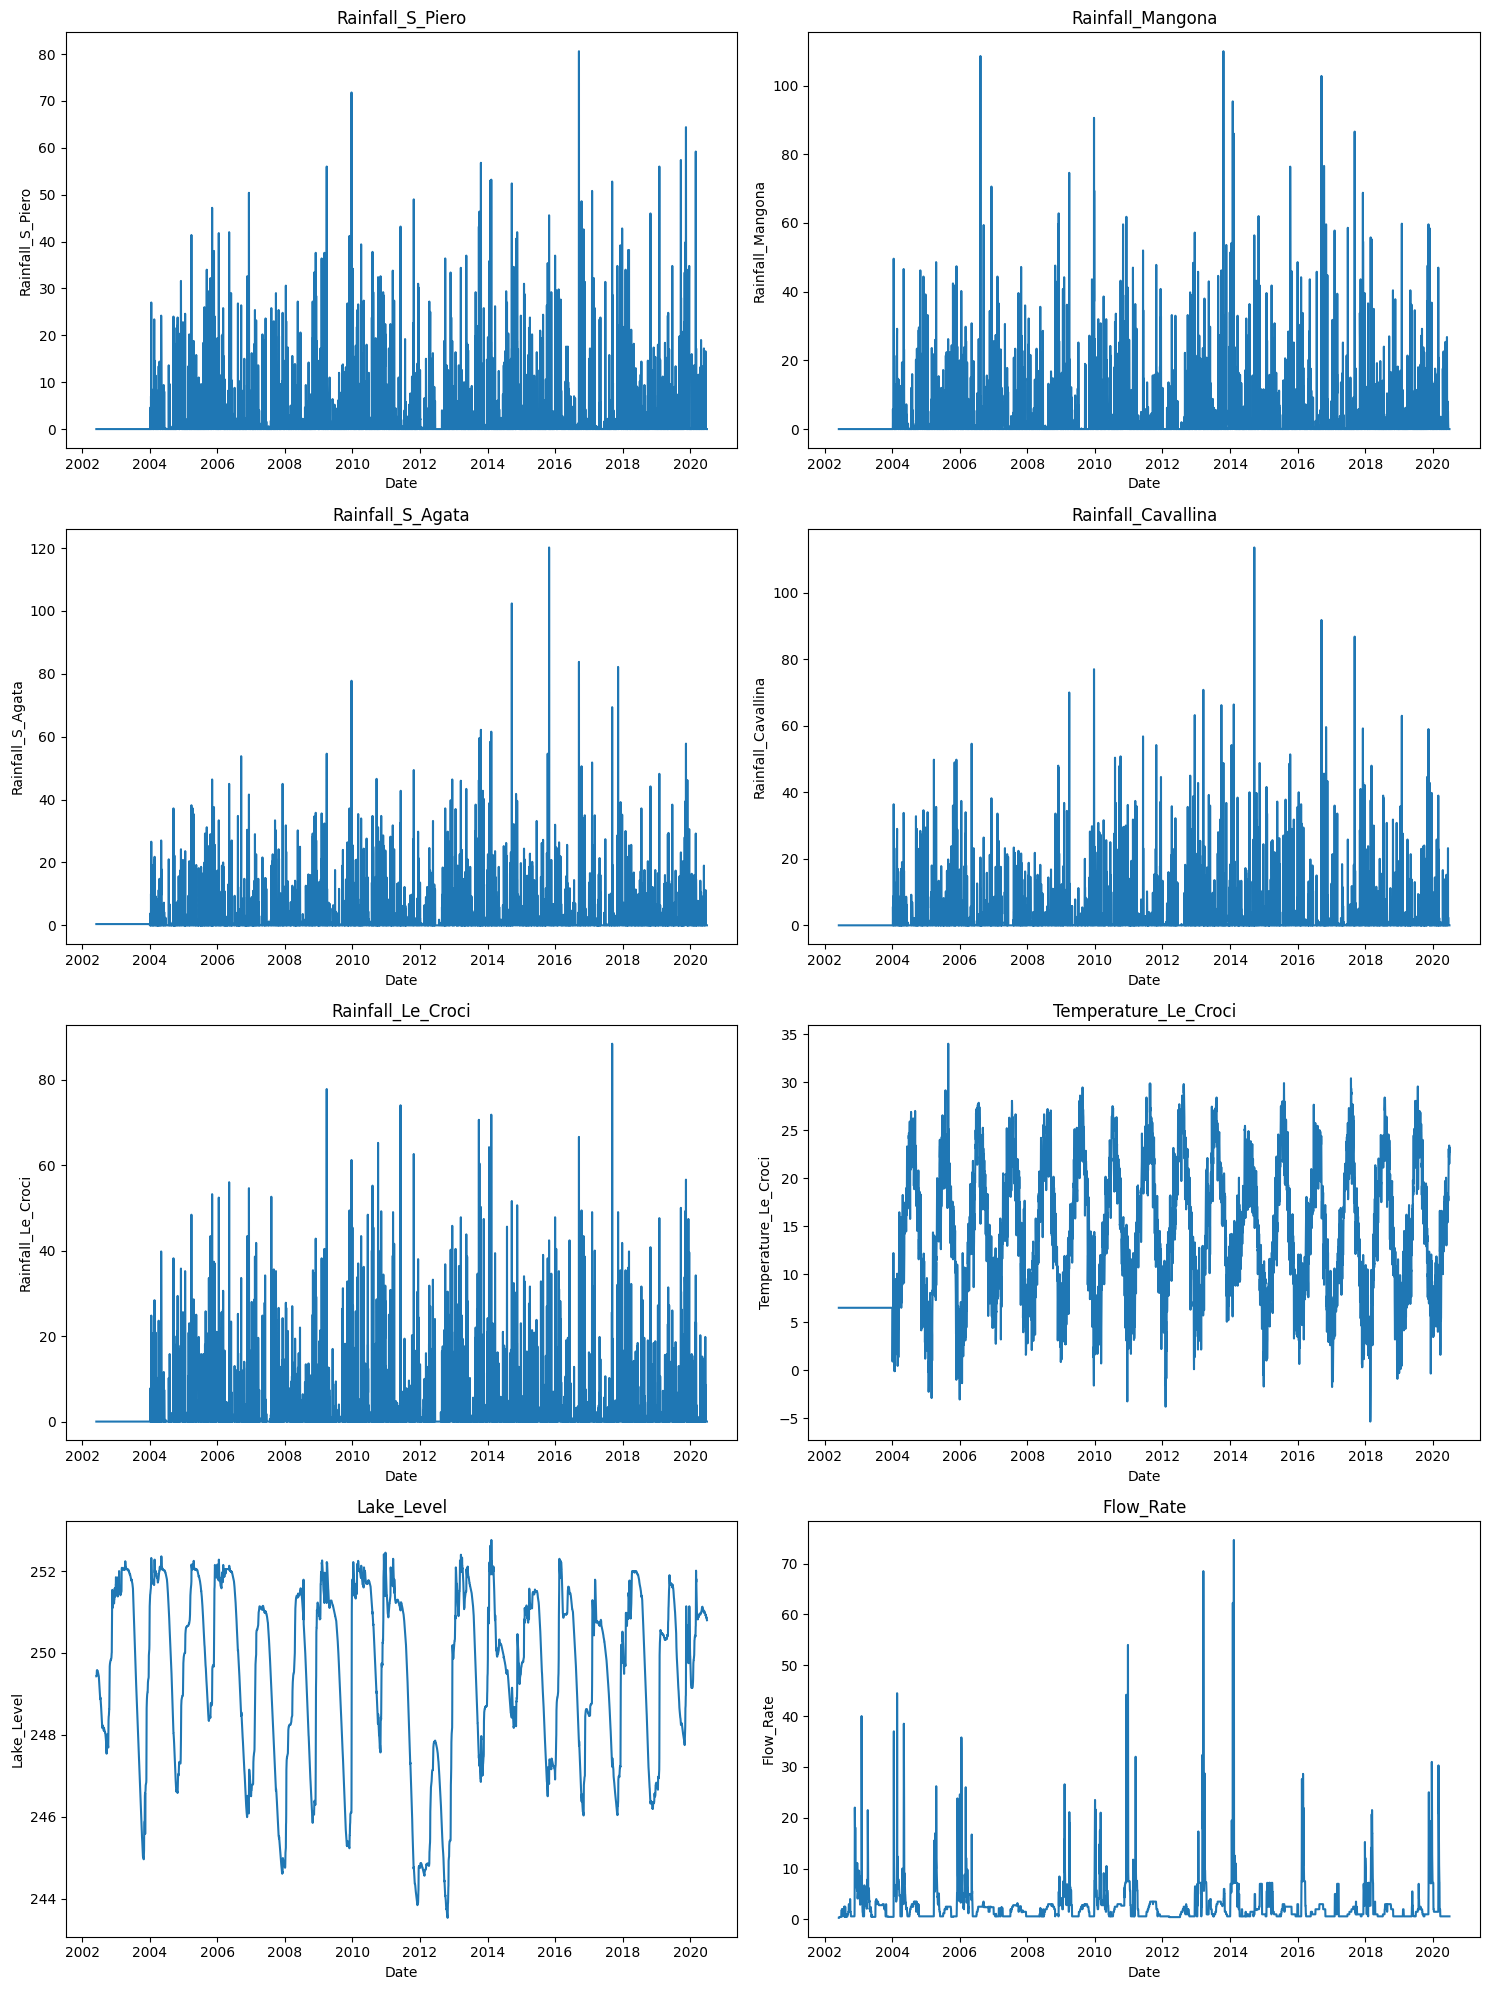

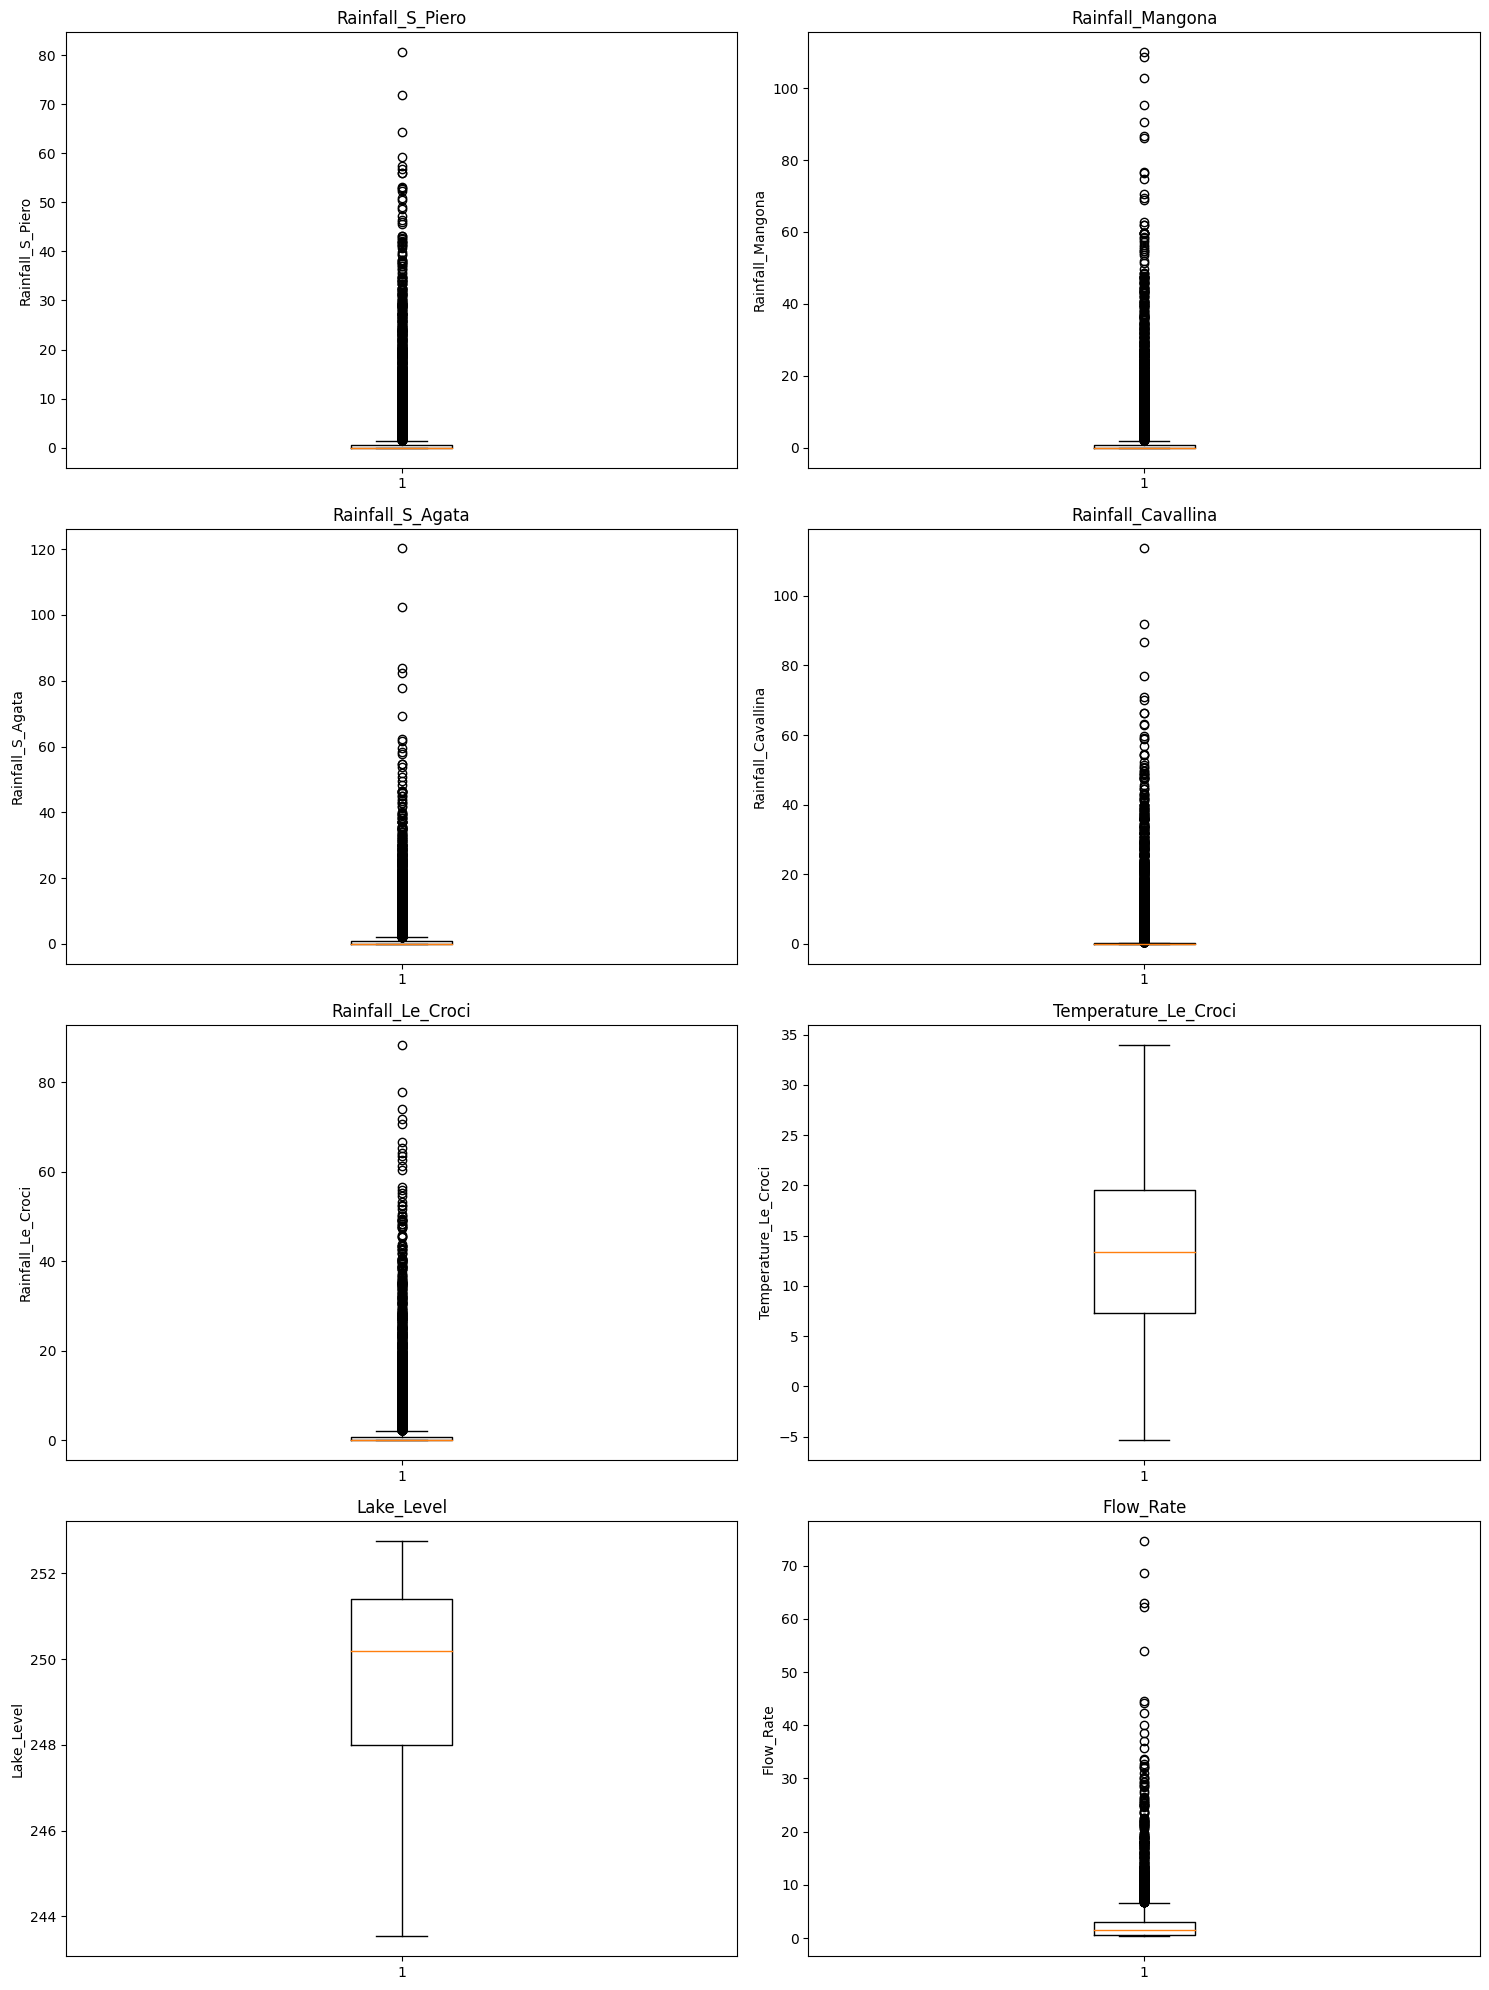

In [30]:
# 设置图的大小
plt.figure(figsize=(15, 20))
# 绘制每个数值变量随时间的变化
for i, column in enumerate(df_smoothed.columns[1:], 1):
    plt.subplot(4, 2, i)
    plt.plot(df_smoothed['Date'], df_smoothed[column])
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel(column)
plt.tight_layout()
plt.show()

# 设置图的大小
plt.figure(figsize=(15, 20))
# 绘制每个数值变量的箱线图
for i, column in enumerate(df_smoothed.columns[1:], 1):
    plt.subplot(4, 2, i)
    plt.boxplot(df_smoothed[column])
    plt.title(column)
    plt.ylabel(column)
plt.tight_layout()
plt.show()

processed_data_path = './dataset/Lake/processed_Lake_Bilancino.csv'
df_smoothed.to_csv(processed_data_path, index=False)